In [1]:
import cv2
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.style.core import available

from photon_canon.contrib.bio import wl, eps
from photon_canon.contrib.bio import hemoglobin_mus
from photon_canon.lut import LUT

from hsdfmpm.hsdfm.utils import find_cycles, gabor_filter_bank, naive_leastsq_reflectance, k_cluster, slice_clusters
from hsdfmpm.fit import distance_to_vasculature, image_reduced_chi_sqaured, make_model_for_vascular_distance, nadh_of_d
from hsdfmpm.utils import apply_kernel_bank, truncate_colormap, colorize
from hsdfmpm.hsdfm import HyperspectralImage, MergedHyperspectralImage
from hsdfmpm.mpm import OpticalRedoxRatio, LifetimeImage

from scipy.optimize import curve_fit
from hsdfmpm.mpm.flim.utils import plot_universal_circle
from tqdm.contrib.itertools import product
from hsdfmpm.hsdfm.fit import fit_voxel

import matplotlib

# Plot fitted curve
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
plt.set_cmap('gray')
plt.close('all')

In [2]:
std_paths = find_cycles(r'D:\Jesse\hsdfmpm_poc\Standards')
bg_paths = find_cycles(r'D:\Jesse\hsdfmpm_poc\Background')
hs_path = r'D:\Jesse\Animal POC\Animals\06052025\Animals\1782NT\10\fov5\cycle1'
flim_path = r'D:\Jesse\Animal POC\Animals\06052025\Animals\1782NT\10\fov5_flim_755-027'
ex755_path = r'D:\Jesse\Animal POC\Animals\06052025\Animals\1782NT\10\fov5_redox_755-026'
ex855_path = r'D:\Jesse\Animal POC\Animals\06052025\Animals\1782NT\10\fov5_redox_855-025'
lsr_pwr_path = r'D:\Jesse\Animal POC\Laser Power'

C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\lut\utils.py:102: UserWarning: Smoothing is not applied to output dataframe. Reshape and apply manually if desired.
  return self.func(instance, owner, *args, **kwargs)


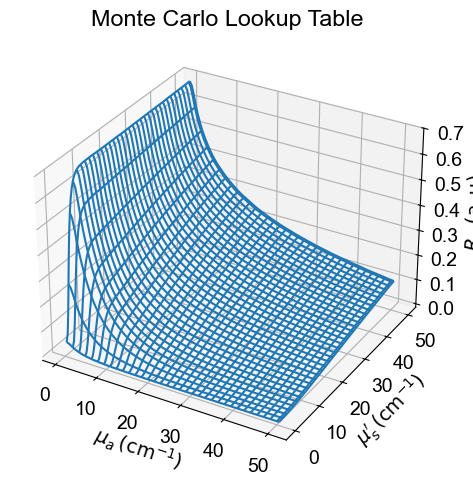

In [3]:
smoothing_fn = partial(cv2.GaussianBlur, ksize=(3, 3), sigmaX=2)
lut = LUT(dimensions=['mu_s', 'mu_a'], scale=50000, extrapolate=True, simulation_id=110, smoothing_fn=smoothing_fn)
X, Y, Z = lut.surface()
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='3d'))
ax.plot_wireframe(Y, X / 10, smoothing_fn(Z))
ax.set(xlabel=r"$\mu_a\, \mathrm{ (cm^{-1})}$", ylabel=r"$\mu_s'\, \mathrm{ (cm^{-1})}$", zlabel=r"$R_m \mathrm{ (a.u)}$", title=r"Monte Carlo Lookup Table")
plt.tight_layout()
plt.show()

In [4]:
# Find raw data
wavelengths = np.arange(500, 730, 10)
absorption_dominated = np.arange(500, 610, 10)
scatter_dominated = np.arange(620, 730, 10)

# Load normalization data
standard = MergedHyperspectralImage(image_paths=std_paths, scalar=0.80, wavelengths=wavelengths)
standard.normalize_integration_time()
background = MergedHyperspectralImage(image_paths=bg_paths, wavelengths=wavelengths)
background.normalize_integration_time()

[None, None, None]

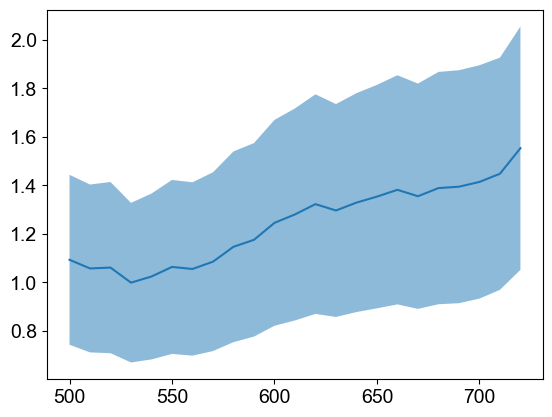

In [5]:
# Load data and normalize
hs = HyperspectralImage(image_path=hs_path, standard=standard, background=background, wavelengths=wavelengths)
hs.normalize()
means = np.nanmean(hs, axis=(1, 2))
wls = hs.metadata['Wavelength']
plt.plot(wls, means)

stdevs = np.nanstd(hs, axis=(1, 2))
plt.fill_between(wls, means - stdevs, means + stdevs, alpha=0.5)
plt.show()
hs.resize_to(256)

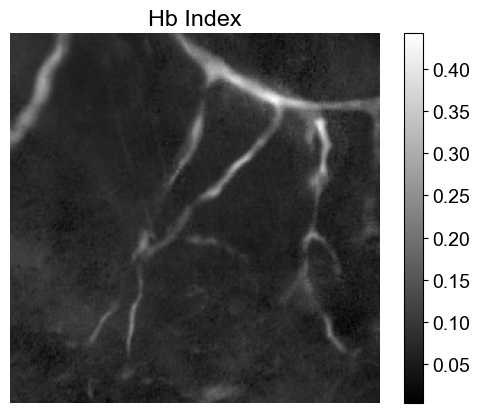

In [6]:
# Get variables for naive fit
selected = np.isin(wl, absorption_dominated)
e = eps[:, selected]

# Fit the image with naive lsq and apply gabor bank
hs.subset_by_metadata("Wavelength", absorption_dominated)
naive_fit = naive_leastsq_reflectance(hs.image, e)
hb_index = naive_fit[0] + naive_fit[1]
plt.imshow(hb_index)
plt.title('Hb Index')
plt.axis('off')
plt.colorbar()
plt.show()

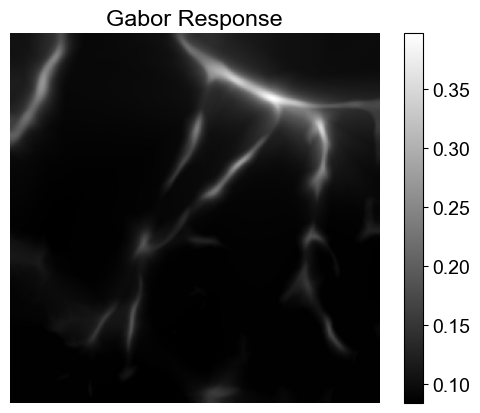

In [7]:
# Apply chosen Gabor design
f = np.geomspace(0.01, 1, 16)
gabor_response = apply_kernel_bank(hb_index, gabor_filter_bank(frequency=f, sigma_x=4/f, sigma_y=1/f))
plt.imshow(gabor_response)
plt.title('Gabor Response')
plt.axis('off')
plt.colorbar()
plt.show()

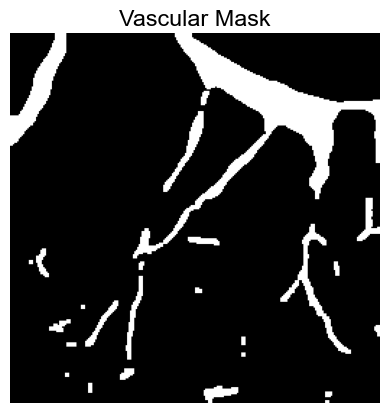

In [8]:
blurred_gabor_response_map = cv2.GaussianBlur(gabor_response, (3, 3), 0.5)
uint8_resp = (255 * (blurred_gabor_response_map / blurred_gabor_response_map.max())).astype(np.uint8)
threshold = (blurred_gabor_response_map.max() / 255) * cv2.threshold(uint8_resp, 0, 255, cv2.THRESH_OTSU)[0]
otsu_mask = blurred_gabor_response_map > threshold
opened_adaptive_mask = cv2.morphologyEx(
    cv2.adaptiveThreshold(uint8_resp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0),
    cv2.MORPH_OPEN,
    np.ones((3, 3))
).astype(bool)
mask = np.logical_or(otsu_mask, opened_adaptive_mask)
fig, ax = plt.subplots(1, 1)
ax.imshow(mask)
ax.axis('off')
ax.set_title('Vascular Mask')
plt.show()

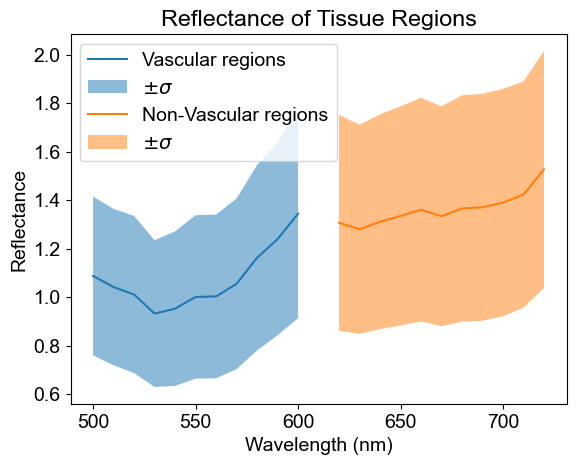

In [9]:
hs.superset()

abs_idx = np.array([wl in absorption_dominated for wl in hs.metadata['Wavelength']])

sca_idx = np.array([wl in scatter_dominated for wl in hs.metadata['Wavelength']])

hs.superset()
total_image = hs.image.copy()
in_data = total_image[abs_idx]
in_data[:, ~mask] = np.nan
out_data = total_image[sca_idx]
out_data[:, mask] = np.nan
in_means = np.nanmean(in_data, axis=(1, 2))
out_means = np.nanmean(out_data, axis=(1, 2))

in_stdevs = np.nanstd(in_data, axis=(1, 2))
out_stdevs = np.nanstd(out_data, axis=(1, 2))

plt.plot(absorption_dominated, in_means, label="Vascular regions")
plt.fill_between(absorption_dominated, in_means - in_stdevs, in_means + in_stdevs, alpha=0.5, label=r"$\pm \sigma$")
plt.plot(scatter_dominated, out_means, label="Non-Vascular regions")
plt.fill_between(scatter_dominated, out_means - out_stdevs, out_means + out_stdevs, alpha=0.5, label=r"$\pm \sigma$")

plt.title('Reflectance of Tissue Regions')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')

plt.legend()
plt.show()

## Fit to non-vasculr space to get scatter-offset/shadow

In [10]:
g = 0.9

mu_s, mu_a, _ = hemoglobin_mus(10, 1, 0, 0, scatter_dominated, force_feasible=False)
mu_s /= (1 - g)
r = lut(mu_s, mu_a)
def baseline_offset(C):
    return r + C

rng = np.random.default_rng(42)
param_image = np.zeros_like(hs.image[0])
chi_sq = np.zeros_like(hs.image[0])
scatter_image = total_image[sca_idx]
for i, j in product(range(0, 256), range(0, 256)):
    if np.all(np.isnan(scatter_image[:, i, j])):
        pi, cs = np.nan, np.nan
    else:
        pi, cs = fit_voxel(
            scatter_image[:, i, j],
            model=baseline_offset,
            x0=[0],
            max_nfev=5000
        )
    param_image[i, j] = pi
    chi_sq[i, j] = cs

C = param_image

  0%|          | 0/65536 [00:00<?, ?it/s]

C:\Users\jdivers\AppData\Local\Temp\ipykernel_242180\3769697138.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  param_image[i, j] = pi


In [41]:
g = 0.9
def model(t, s):
    mu_s, mu_a, _ = hemoglobin_mus(10, 1, t, s, absorption_dominated, force_feasible=False)
    mu_s /= (1 - g)
    r = lut(mu_s, mu_a, extrapolate=True)
    return r

rng = np.random.default_rng(42)
param_image = []
chi_sq = []
param_image = np.zeros_like(in_data[0:2])
chi_sq = np.zeros_like(in_data[0])
for i, j in product(range(256), range(256)):
    if np.any(np.isnan(in_data[:, i, j])):
        pi, cs = np.array([np.nan, np.nan]), 100000
    else:
        pi, cs = fit_voxel(
            in_data[:, i, j] - C[i, j],
            model=model,
            x0=[10, 0.5],
            bounds=((0, 0), (np.inf, 1)),
            max_nfev=5000
        )
    param_image[:, i, j] = pi
    chi_sq[i, j] = cs

  0%|          | 0/65536 [00:00<?, ?it/s]

In [42]:
thb, so2 = param_image
available_o2 = 4 * thb * so2
chi_sq[chi_sq<100000].mean()

np.float64(1.2281952866765253)

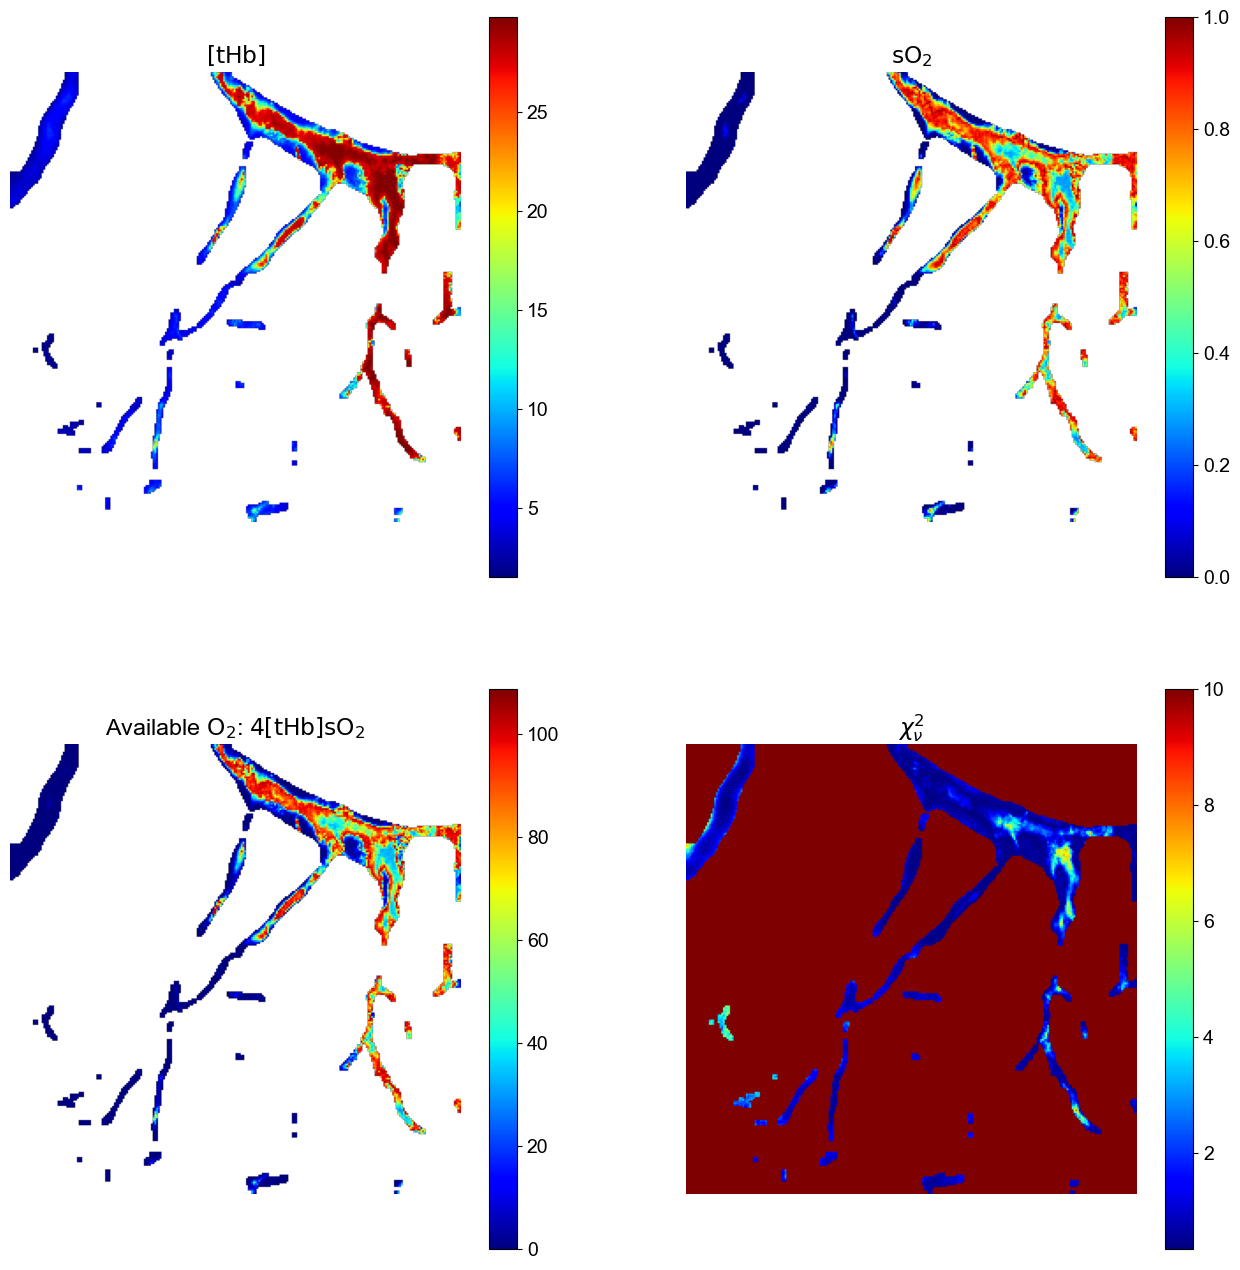

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
im = ax[0,0].imshow(thb, cmap='jet')
ax[0,0].set_axis_off()
ax[0,0].set(title=r"$\mathrm{[tHb]}$")
fig.colorbar(im, ax=ax[0,0])

im = ax[0,1].imshow(so2, cmap='jet')
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_axis_off()
ax[0,1].set(title=r"$\mathrm{sO_2}$")

im = ax[1, 0].imshow(available_o2, cmap="jet")
fig.colorbar(im, ax=ax[1, 0])
ax[1,0].set_axis_off()
ax[1,0].set(title=r"Available $\mathrm{O_2}$: $4\mathrm{[tHb]sO_2}$")

im = ax[1,1].imshow(chi_sq, cmap='jet', vmax=10)
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_axis_off()
ax[1,1].set(title=r"$\chi^2_\nu$")
plt.show()

# ORR

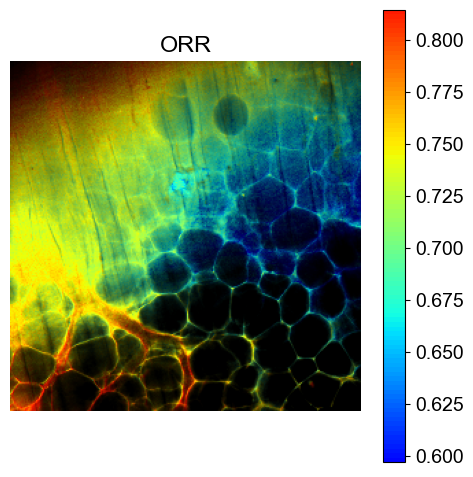

In [44]:
# Load images
orr = OpticalRedoxRatio(
    ex755=ex755_path,
    ex855=ex855_path,
    power_file_path=lsr_pwr_path)

# Down sample for SNR and to match HSDFM
orr.resize_to(256)

# Create outputs
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
cmin, cmax = np.mean(orr.map) + np.array([-2, 2]) * np.std(orr.map)
color_orr, cmap = orr.colorize(cmap=cmap, cmin=cmin, cmax=cmax)
fig = plt.figure(figsize=(5, 5))
plt.imshow(color_orr, cmap=cmap)
ax = plt.gca()
ax.set_title('ORR')
ax.axis('off')
sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
plt.colorbar(sm, ax=ax)
plt.tight_layout()

# FLIM

C:\Users\jdivers\PycharmProjects\hsdfmpm\src\hsdfmpm\mpm\flim\flim.py:72: Warning: Loading default IRF file, 'C:\Users\jdivers\.hsdfmpm\irf\irf.pkl'.
  self.calibration = get_irf(irf)


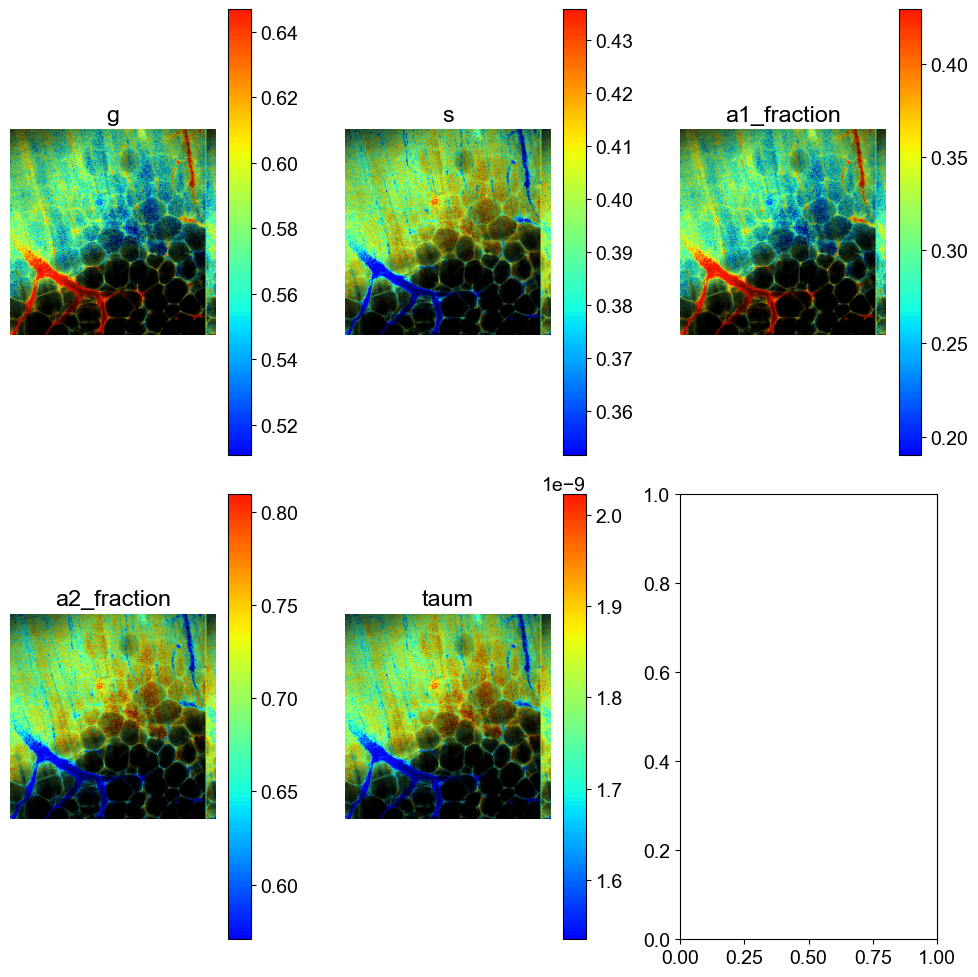

In [45]:
decay = LifetimeImage(image_path=flim_path, channels=0)
decay.load_irf()  # IRF was previously stored
decay.resize_to(256)

# Calculate phasor coords and fit-line endpoints
g, s = decay.phasor_coordinates(threshold=0, correction=True)
alphas, taum, tau = decay.fit_for_lifetime_approximations()
a2_fraction = alphas[1] / (alphas[0] + alphas[1])
a1_fraction = alphas[0] / (alphas[0] + alphas[1])

cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
for png_name, im, ax in zip(['g', 's', 'a1_fraction', 'a2_fraction', 'taum'], [g, s, a1_fraction, a2_fraction, taum], axes.flat):
    cmin, cmax = np.mean(im) + np.array([-2, 2]) * np.std(im)
    color_var, cmap = colorize(im.squeeze(), np.nansum(decay.decay, axis=-1).squeeze(), cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'{png_name}')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()
plt.show()

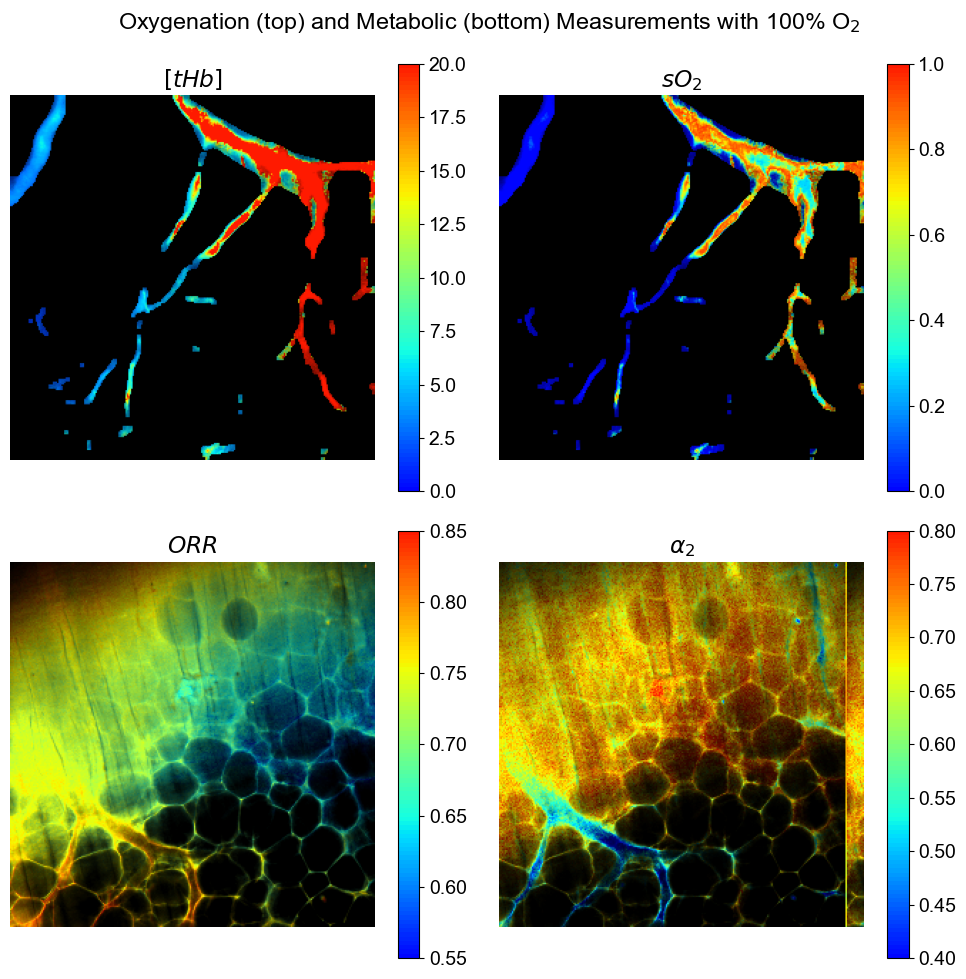

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Oxygenation (top) and Metabolic (bottom) Measurements with 100% O$_2$')
cmap = truncate_colormap('jet', cmin=0.13, cmax=0.88)
for name, varim, intim, ax, (cmin, cmax) in zip(
    ['[tHb]', 'sO_2', 'ORR', r'\alpha_2'],
    [thb, so2, orr.map, a2_fraction],
    [(hb_index * mask).squeeze(), (hb_index * mask).squeeze(), ((orr.fad + orr.nadh) / 2).squeeze(), (np.nansum(decay, axis=-1) * np.nansum(decay, axis=-1)).squeeze()],
    axes.flat,
    [(0, 20), (0, 1), (0.55, 0.85), (0.4, 0.8)]
):
    color_var, cmap = colorize(varim, intim, cmap=cmap, cmin=cmin, cmax=cmax)
    ax.imshow(color_var, cmap=cmap)
    ax.set_title(f'${name}$')
    ax.axis('off')
    sm = plt.cm.ScalarMappable(norm=Normalize(vmin=cmin, vmax=cmax), cmap=cmap)
    plt.colorbar(sm, ax=ax)
plt.tight_layout()


In [47]:
decay.aspect_ratio, decay.p_value

(np.float64(3.7459434061153143), np.float64(0.023621097702641928))

[(0.0, 1.0), (0.0, 0.6), None]

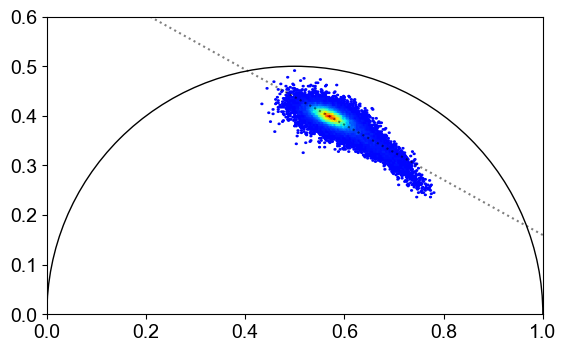

In [48]:
g, s = decay.phasor_coordinates()
b, m = decay.get_phasor_line()['point-slope']
plt.axline((0, b), slope=m, linestyle=':', color='black', alpha=0.5, label="Fit line")
plt.hexbin(g, s, cmap=cmap, mincnt=1)
plot_universal_circle(decay.omega, harmonic=0.5)
plt.gca().set(xlim=[0, 1], ylim=[0, 0.6], aspect=1)

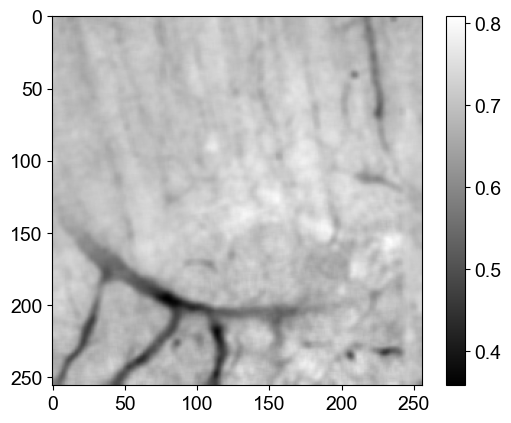

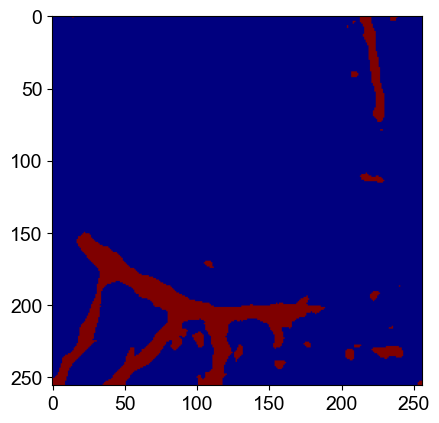

In [49]:
blurred = cv2.GaussianBlur(a2_fraction, (5,5), 3)
clusters = k_cluster(blurred, 2)
a2_mask = slice_clusters(blurred, clusters, slice(0, 1, None))
plt.imshow(blurred)
plt.colorbar()
plt.show()
plt.imshow(a2_mask, cmap='jet')

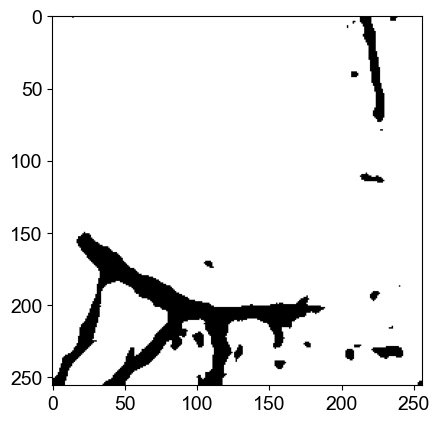

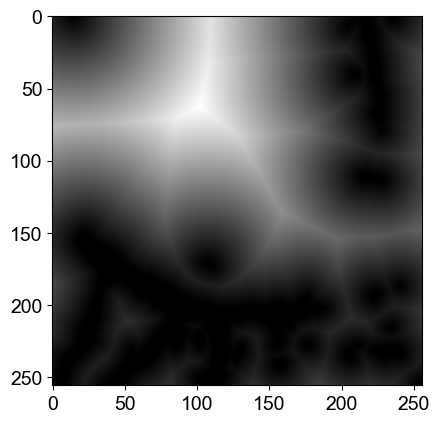

In [50]:
plt.imshow(~a2_mask)
plt.show()
plt.imshow(distance_to_vasculature(a2_mask))

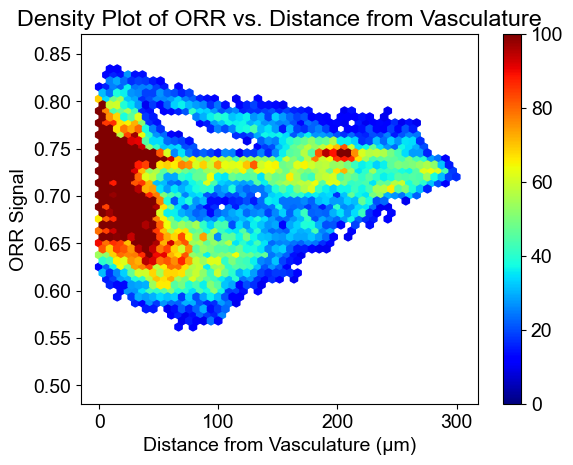

In [51]:
dtv = distance_to_vasculature(a2_mask, um_per_pixel=1.414 * 2)
plt.hexbin(dtv.flatten(), orr.map.flatten(), gridsize=50, cmap='jet', mincnt=10, vmin=0, vmax=100)
plt.colorbar()
plt.xlabel('Distance from Vasculature (µm)')
plt.ylabel('ORR Signal')
plt.title('Density Plot of ORR vs. Distance from Vasculature')
plt.show()

In [52]:
# Fit the curve
x_data = dtv[~a2_mask]
y_data = orr.nadh[~a2_mask]
p0 = [100, 2, 0, 26.6, 1]

nadh_of_d = make_model_for_vascular_distance("nadh", sO2_0=np.nanmean(so2))

params, cov = curve_fit(
    nadh_of_d,
    x_data,
    y_data,
    p0=p0,
    bounds=[
        (0,           0,      0,   0, -np.inf),
        (np.inf, np.inf, np.inf, 160,  np.inf)
    ],
    maxfev=1000,
)
diff_limit, A1, A2, p50, dx = params

In [53]:
y_fit = nadh_of_d(np.sort(x_data), *params)
chi_sq = image_reduced_chi_sqaured(x_data, y_fit, len(params), 2)

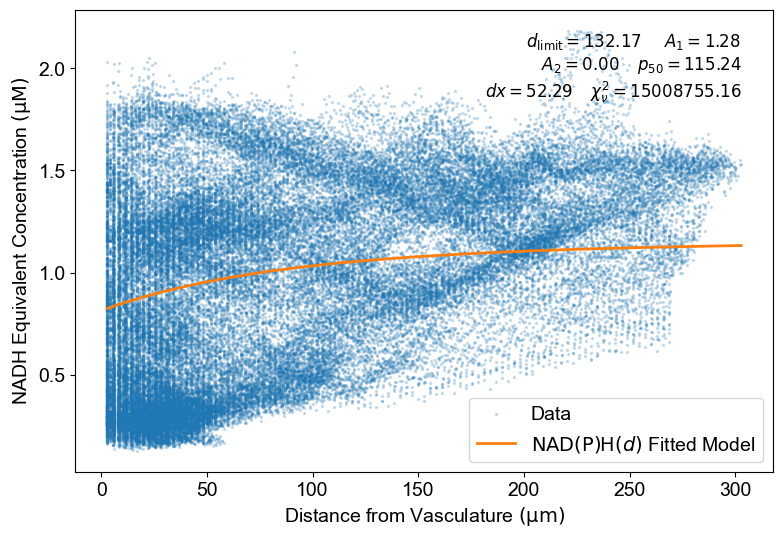

In [54]:

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x_data, y_data, s=2, alpha=0.2, label='Data')
ax.plot(np.sort(x_data), y_fit, color="C1", linewidth=2, label=r'$\mathrm{NAD(P)H}\left(d\right)$ Fitted Model')
ax.set(xlabel=r'Distance from Vasculature $\mathrm{(\mu m)}$', ylabel=r'NADH Equivalent Concentration $\mathrm{(\mu M)}$')
ax.text(dtv.max(), orr.nadh.max(),
        fr"$d_\mathrm{'{limit}'} = {diff_limit:.2f}$"
        "\t"
        fr"$A_1 = {A1:.2f}$"
        "\n"
        fr"$A_2 = {A2:.2f}$"
        "\t"
        fr"$p_{'{50}'} = {p50:.2f}$"
        "\n"
        fr"$dx = {dx:.2f}$"
        "\t"
        fr"$\chi^2_\nu = {chi_sq:.2f}$",
         ha="right", va="top", fontsize=12)
ax.legend(loc="lower right")
plt.show()